In [1]:
!pip install transformers==4.19.4
!pip install datasets==2.13.1
!pip install evaluate==0.4.0
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 50.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.0
    Uninstalling tokenizers-0.15.0:
      Successfully uninstalled tokenizers-0.15.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━

In [2]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from datasets import DatasetDict, Dataset, load_dataset, concatenate_datasets

from transformers import (
    Trainer,
    TrainingArguments,
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from huggingface_hub import notebook_login

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
os.environ['TOKENIZERS_PARALLELISM'] = 'false' # there might be interferences with the parallelism of the Hugging Face Trainer

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [8]:
def tokenize_data(filepath:str='/content/drive/MyDrive/citation_sentiment_data/folds/', number_of_files:int=10):

  def tokenize_seqs(examples):
      return tokenizer(examples['citation'], padding = True, truncation=True, max_length=512, return_tensors="pt")

  folds_dict = {}

  for i in range(number_of_files):
      df_name = f'fold_{i+1}'
      df = pd.read_csv(f'{filepath}{df_name}.csv')
      folds_dict[df_name] = df

  for f in folds_dict:
    folds_dict[f] = Dataset.from_pandas(folds_dict[f])

  dataset = DatasetDict(folds_dict)

  def tokenize_seqs(examples):
      return tokenizer(examples['citation'], padding = True, truncation=True, max_length=512, return_tensors="pt")

  tokenized_data = dataset.map(tokenize_seqs, batched=True)
  tokenized_data = tokenized_data.rename_column('label', 'labels')

  return tokenized_data

tokenized_data = tokenize_data()

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

Map:   0%|          | 0/798 [00:00<?, ? examples/s]

In [9]:
def compute_metrics(eval_preds):
    y_true = eval_preds.label_ids
    y_pred = eval_preds.predictions.argmax(axis=1)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {'f1': f1}

In [10]:
# creating a list of all folds
fold_list = [tokenized_data[f'fold_{i+1}'] for i in range(10)]
# selecting one fold as eval set based on its index
eval_data = fold_list[0]
train_folds = fold_list.copy()
del train_folds[0]
train_data = concatenate_datasets(train_folds)

Class distribution:  [87.59398496 12.40601504]




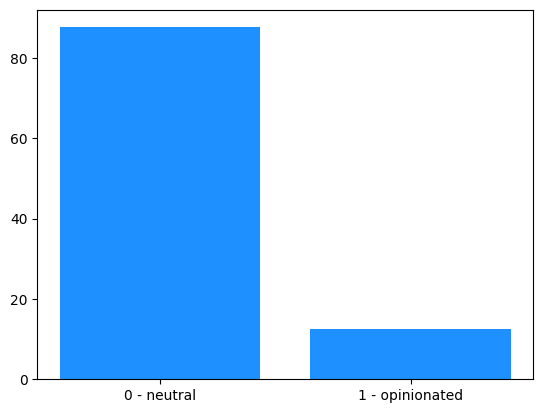

In [11]:
df = train_data.to_pandas()
class_distribution = (df['labels'].value_counts(normalize=True, sort=False) * 100).sort_index().to_numpy()
# obtained manually by checking after spotting mistake by final review
x = ['0 - neutral', '1 - opinionated']
y = class_distribution
plt.bar(x, y, color='dodgerblue')
print("Class distribution: ", class_distribution)
print('\n')
plt.show()

In [12]:
complement_weights = 1 - (class_distribution / 100)
complement_weights = torch.tensor(complement_weights, dtype=torch.float32).to(device)

In [14]:
class BalancedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=complement_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [19]:
per_device_train_batch_size = 4
training_args = TrainingArguments(
    output_dir ='./logs/fold1_v0.11',
    per_device_train_batch_size = per_device_train_batch_size,
    per_device_eval_batch_size  = per_device_train_batch_size*4,
    learning_rate = 2e-5,
    weight_decay = 1e-3,
    num_train_epochs = 3,
    evaluation_strategy = 'epoch',
    logging_strategy = 'steps',
    logging_steps = len(train_data) / per_device_train_batch_size,
    save_strategy = 'epoch',
    save_total_limit = 1,
    seed = 42,
    data_seed = 42,
    fp16 = True,
    dataloader_num_workers = 2,
    load_best_model_at_end = True,
)

trainer = BalancedLossTrainer(model=model, args=training_args, compute_metrics = compute_metrics, train_dataset = train_data, eval_dataset = eval_data, tokenizer = tokenizer)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using amp half precision backend


In [20]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: citation. If citation are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7182
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5388


Epoch,Training Loss,Validation Loss,F1
1,No log,0.805346,0.909538
2,0.934700,1.253140,0.910769
3,0.934700,0.975815,0.906931


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: citation. If citation are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 798
  Batch size = 16
Saving model checkpoint to ./logs/fold1_v0.11/checkpoint-1796
Configuration saved in ./logs/fold1_v0.11/checkpoint-1796/config.json
Model weights saved in ./logs/fold1_v0.11/checkpoint-1796/pytorch_model.bin
tokenizer config file saved in ./logs/fold1_v0.11/checkpoint-1796/tokenizer_config.json
Special tokens file saved in ./logs/fold1_v0.11/checkpoint-1796/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: citation. If citation are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Runn

TrainOutput(global_step=5388, training_loss=0.8167949809617437, metrics={'train_runtime': 935.1848, 'train_samples_per_second': 23.039, 'train_steps_per_second': 5.761, 'total_flos': 6138030503227392.0, 'train_loss': 0.8167949809617437, 'epoch': 3.0})

In [37]:
# save best model on huggingface
!mkdir impact_cite_v0.11
model.save_pretrained('impact_cite_v0.11')

mkdir: cannot create directory ‘impact_cite_v0.11’: File exists


Configuration saved in impact_cite_v0.11/config.json
Model weights saved in impact_cite_v0.11/pytorch_model.bin


In [40]:
eval_predictions = trainer.predict(eval_data)
print(f"F1 score on validation set fold 1: {eval_predictions[2]['test_f1']}")

The following columns in the test set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: citation. If citation are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 798
  Batch size = 16


F1 score on validation set fold 1: 0.9095377465150253


Correct counts per class: [682.  47.]
Wrong counts per class: [26. 43.]
Class distribution test set:  [708.  90.]
Correct predictions per class in percent:  [0.96327684 0.52222222]
Wrong predictions per class in percent:  [0.03672316 0.47777778]




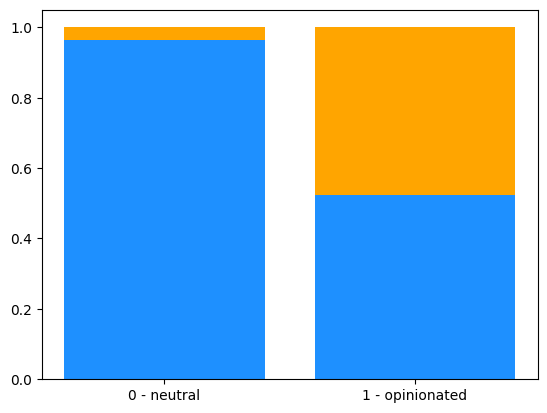

In [41]:
# extract predictions and labels
y_pred = eval_predictions[0].argmax(1)
y_true = eval_predictions[1]
# getting the absolute coorect and wrong predictions per class
correct_predictions = np.array(y_pred) == np.array(y_true)
correct_counts_per_class = np.bincount(y_true, weights=correct_predictions)
print("Correct counts per class:", correct_counts_per_class)
wrong_predictions = np.array(y_pred) != np.array(y_true)
wrong_counts_per_class = np.bincount(y_true, weights=wrong_predictions)
print("Wrong counts per class:", wrong_counts_per_class)
# creating an overall absolute class distribution of the test set
class_distribution = correct_counts_per_class + wrong_counts_per_class
print("Class distribution test set: ", class_distribution)
# calculating percentages of correct and wrong predictions per class
correct_pred_labels_percent = correct_counts_per_class/class_distribution
wrong_pred_labels_percent = wrong_counts_per_class/class_distribution
print("Correct predictions per class in percent: ", correct_pred_labels_percent)
print("Wrong predictions per class in percent: ", wrong_pred_labels_percent)
# stacked barchart with correct and wrong predictions per class in percent
x = ['0 - neutral', '1 - opinionated']
y1 = correct_pred_labels_percent
y2 = wrong_pred_labels_percent
plt.bar(x, y1, color='dodgerblue')
plt.bar(x, y2, bottom=y1, color='orange')
print('\n')
plt.show()

In [43]:
from google.colab import files
!zip -r /content/impact_cite_v0.11.zip /content/impact_cite_v0.11
files.download("/content/impact_cite_v0.11.zip")

  adding: content/impact_cite_v0.11/ (stored 0%)
  adding: content/impact_cite_v0.11/config.json (deflated 52%)
  adding: content/impact_cite_v0.11/pytorch_model.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>